### Платформа ОФД. Задание для кандидатов на позицию DS

 Цель задания
 
    Проверить знания, навыки и логическое мышление кандидатов на вакансию Data Scientist на примере
    задачи, близкой к тем, с которыми предстоит работать на указанной позиции.
    Для решения задачи разрешается использовать любые методы и средства, в том числе это означает, что
    использование машинного обучения не является обязательным. Методика оценки результатов также
    остается на усмотрение кандидата.

In [44]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
# from catboost import CatBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
# from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import tqdm

from utils import confusion_matrix_with_names, show_score, evaluate_model, get_features_list, simple_preprocessor


In [2]:
#load datasets
df_test = pd.read_csv('../test_dataset.txt', sep = '\t')
df = pd.read_csv('../training_dataset.txt', sep = '\t')

print('df_test.shape', df_test.shape)
print('df.shape', df.shape)

df_test.shape (19989, 1)
df.shape (9998, 2)


In [3]:
### Есть ли лик из теста в трейн
set(df_test['name'].apply(hash)) & set(df['name'].apply(hash))

set()

In [4]:
print('df.shape', df.shape)
df.head()

df.shape (9998, 2)


name                result
0                  1.вода аква минерале газ 0.  НЕ Сигареты ROTHMANS
1                               сигареты"keht"  НЕ Сигареты ROTHMANS
2  сигареты стиль rose ssl jade (жадэ розовый)  НЕ Сигареты ROTHMANS
3                     мин вода нарзан 0.5л пэт  НЕ Сигареты ROTHMANS
4                        пирожок печен с мясом  НЕ Сигареты ROTHMANS

### Посмотрим на распределение классов

In [5]:
df['result'].value_counts()

НЕ Сигареты ROTHMANS                                                                            9200
Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)                        222
Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)     185
Сигареты ROTHMANS DEMI                                                                           172
Сигареты ROTHMANS DEMI SILVER (серый)                                                             76
Сигареты ROYALS BY ROTHMANS                                                                       75
Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)        59
Сигареты ROTHMANS (неизвестно или нет в списке)                                                    9
Name: result, dtype: int64

#### Проверим количество дубликатов

In [6]:
if df['name'].nunique()==len(df):
    print('Полных дубликатов нет')

Полных дубликатов нет


Что можно заметить
    - сильный дисбаланс классов
    - некоторые классы по смыслу пересекаются между собой
    
Посмотрим глазами на примеры классов

In [7]:
classes = df['result'].unique()

In [8]:
# Выведем по три примера для каждого класса
for key, val in df['result'].value_counts().to_dict().items():
    print('\n\n'+key+'\n[%d]'%val)
    print('\t'+str(df.loc[df['result']==key, 'name'].sample(3)).replace('\n', '\n\t'))



НЕ Сигареты ROTHMANS
[9200]
	5795                       260р гирлянда+ плакат
	6101               эссе blue super slims мрц 120
	5029    мармелад тм "яшкино" бегемотик бонди 70г
	Name: name, dtype: object


Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)
[222]
	5757    сигареты ротманс деми клик шт мрц 95
	5831            rothmans demi клик кнопка ss
	8286             сиг.ротманс деми клик (100)
	Name: name, dtype: object


Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)
[185]
	6670                сигареты ротманс деми амбер 95 р
	9344    00004289 сигареты ротманс деми kлик мандарин
	6511               сигареты trothmans demi plus (95)
	Name: name, dtype: object


Сигареты ROTHMANS DEMI
[172]
	4070          сиг ротманс деми..
	1997      ротманс деми син. 6 ка
	8087    сигарет pотманс деми 95р
	Name: name, dtype: object


Сигареты ROTHMANS DEMI SILVER (серый)
[76]
	106      сигареты ротманс деми сильвер 1пач.
	263 

In [9]:
rename_dict = {'НЕ Сигареты ROTHMANS'  : "NOT", 
               'Сигареты ROTHMANS DEMI' : "DEMI", 
               'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)' : "Aero Blue",
               'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)' : "Plus Blue",
               'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)' : "DEMI CLICK",
               'Сигареты ROTHMANS DEMI SILVER (серый)' : "DEMI SILVER",
               'Сигареты ROYALS BY ROTHMANS' : "ROYALS BY",
               'Сигареты ROTHMANS (неизвестно или нет в списке)' : "WRONG CHECK"
              }

rename_dict_inverse = {v:k for k,v in rename_dict.items()}

df['y'] = df['result'].apply(lambda x: rename_dict[x])
assert df['y'].nunique()==df['result'].nunique()

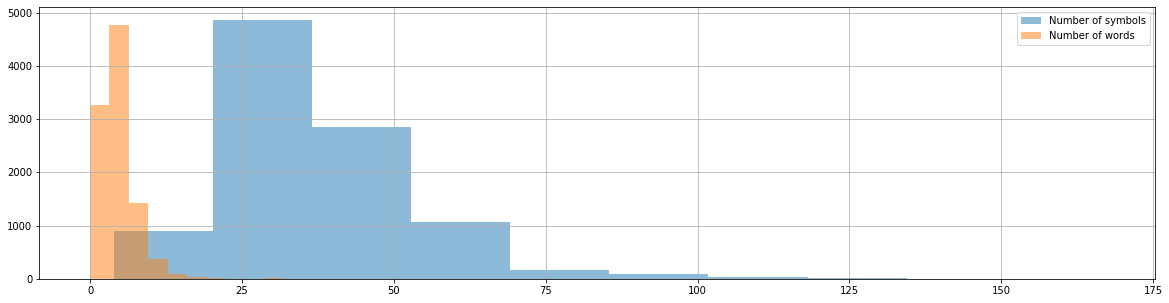

NOT            9200
DEMI CLICK      222
Plus Blue       185
DEMI            172
DEMI SILVER      76
ROYALS BY        75
Aero Blue        59
WRONG CHECK       9
Name: y, dtype: int64

In [10]:
# Посмотрим на среднюю длинну чека
df['name'].apply(len).hist(label = 'Number of symbols', alpha = 0.5, figsize = (20, 5))
df['name'].apply(lambda x:x.count(' ')).hist(label = 'Number of words', alpha = 0.5)
plt.legend()
plt.show()

df['y'].value_counts()

### Краткий план работы
<img src="desctiprion.jpeg" width=400, height=400></img>

    В качестве baseline модели обучим самую простую модель и посмотрим на ее качество (TF-IDF + SVC)
    (не задумываясь о смысле классов или о чем либо другом)
 
    В нормальной модели будем использовать двухуровневуб модель
        M1 Модель сигареты rothmans / не сигареты rothmands
        M2 Модель подкатегорий для сигарет rothmands
            
    В качестве метрики, будем использовать precision и recall по классам
    Для сравнения двух моделей будем использовать F0.1 (F_betta, betta = 0.1)
    Почему именно F0.1 - потому что для нас важнее Precision чем Recall
    
    Мое предполодение следующее, в дальнейшем эти результаты могут быть использованы для аналитики продаж сигарет по времени 
    Самые простые вопросы которые нас могут интересовать:
        1. Как часто продают сигареты марки rothmands?
        2. Как меняются доли продуктов внутри сигарет марки rothmands?
        3. За какую цену продают эти сигареты в магазинах?
    
    П1 
        Для 1 и 2, нам нужно чтобы модель была стабильна по времени (например не использовала признаки по типу "100руб")
    П2
        Для 3 - на выделенных текстах будет применена модель с выделением цены, 
        чтобы не обрабатывать лишних записей, ошибки FP хуже чем ошибки FN
    
    Для выполнения П1, будем руками отсеивать неинтерпретируемые признаки (например слово "МЦТ" или цену)
    Для выполнения П2, будем подбирать гиперпараметры модели, смотря на F0.1

In [11]:
# Создадим класс y_M1
df['y_M1'] = df['y'].apply(lambda x: x if x=='NOT' else 'Rothmands')

In [12]:
fold = StratifiedKFold(n_splits = 4, random_state=42)

In [13]:
"""
Были перепробованы следующие модели: 
    logreg({l1,l2}, C={0.01,0.1, 1, 10}), 
    RandomForest, 
    GradientBoosting(Catboost), 
    SVM(linear, rbf)
"""
# SVM показал лусшие результаты

baseline_model = Pipeline([('Tf-IDF', TfidfVectorizer(lowercase=True,
                                                      preprocessor=lambda x:x.replace('"', ' ').replace("''", ' '),
                                                      ngram_range=(1,1), max_features=100)),
                           ('SVM', SVC(kernel='linear', probability=True, class_weight='balanced', gamma='auto'))])


# Запускаем обучение
y_truth, y_predict_list, texts = evaluate_model(df['name'].to_numpy(), df['y'].to_numpy(), baseline_model, fold)

# Выводим рузультат в виде confusion_matrix
confusion_matrix_with_names(y_truth, y_predict_list)

# Выведем precision и recall по классам
labels = [i[0] for i in sorted(Counter(y_truth).items(), key = lambda x:-x[1])]
print(classification_report(y_truth, y_predict_list, labels = labels, digits=5))

/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()


classes:  NOT         DEMI CLICK  Plus Blue   DEMI        DEMI SILVER ROYALS BY   Aero Blue   WRONG CHECK
Pr:       0.9991      0.7708      0.8000      0.4253      0.8500      0.2500      0.1667      nan        
Rec:      0.9978      0.6607      0.6809      0.8605      0.8947      0.0526      0.0667      0.0000     
F01:      0.9991      0.7696      0.7986      0.4274      0.8504      0.2411      0.1642      nan        


/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()


classes:  NOT         DEMI CLICK  Plus Blue   DEMI        DEMI SILVER ROYALS BY   Aero Blue   WRONG CHECK
Pr:       0.9983      0.7321      0.9643      0.4444      0.7895      0.3750      nan         nan        
Rec:      0.9978      0.7321      0.5870      0.9302      0.7895      0.1579      0.0000      0.0000     
F01:      0.9983      0.7321      0.9582      0.4468      0.7895      0.3700      nan         nan        


/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()


classes:  NOT         DEMI CLICK  Plus Blue   DEMI        DEMI SILVER ROYALS BY   Aero Blue   WRONG CHECK
Pr:       0.9983      0.6935      0.9583      0.4762      1.0000      0.6000      0.5000      nan        
Rec:      0.9987      0.7818      0.5000      0.9302      0.7895      0.1579      0.2667      0.0000     
F01:      0.9983      0.6943      0.9497      0.4785      0.9974      0.5838      0.4957      nan        
classes:  NOT         DEMI CLICK  Plus Blue   DEMI        DEMI SILVER ROYALS BY   Aero Blue   WRONG CHECK
Pr:       0.9987      0.7115      0.7111      0.4583      0.8000      1.0000      0.3333      nan        
Rec:      0.9987      0.6727      0.6957      0.7674      0.6316      0.2222      0.2143      0.0000     
F01:      0.9987      0.7111      0.7110      0.4602      0.7979      0.9665      0.3315      nan        

fold mean (class median (F01)) 0.7340


Pred\True  |NOT        |DEMI CLICK |Plus Blue  |DEMI       |DEMI SILVER|ROYALS BY  |Aero Blue  |WRONG CHECK|
NO

/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
# Предскажем на тесте используя baseline модель
_ = baseline_model.fit(df['name'].to_numpy(), df['y'].to_numpy())
df_test['predict_baseline'] = baseline_model.predict(df_test['name'])

### В дальнейшем будем сравнивать результаты с этой моделью

    В качестве модели - будем использовать SVC, он достаточно быстрый и показывает хорошие результаты
    Для улучшения всего алгоритма, будем в первую очередь менять препроцессинг и словарь

## Модель для категорий (M1)

/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/

Text(0, 0.5, 'Number of features')

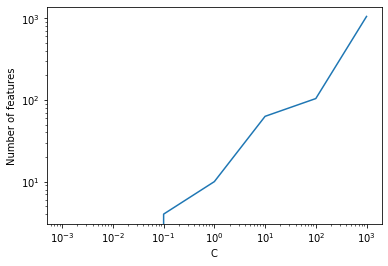

In [15]:
## Узнаем самые часто встречаемые признаки
## Оставим только интерпретируемые глазами признаки
X, y = df['name'].to_numpy(), df['y_M1'].to_numpy()
C_log = list(map(lambda x:10**x, np.linspace(-3,3,7)))
y_list = []
for C in tqdm.tqdm_notebook(C_log):
    used_features = get_features_list(C, X, y)
    y_list.append(len(set(used_features)))
    
plt.plot(C_log, y_list)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('Number of features')

Выберем С = 75

In [16]:
used_features = get_features_list(150, X, y)
print('["'+'", "'.join(list(set(used_features)))+'"]')

["деми клик", "сигареты", "96", "сигарет", "амбер", "аэро", "клик", "сигаретыротманс", "рот манс деми", "50", "нежн", "оплата", "футболка", "сифон для", "сифон", "40", "для", "деми амбер мандарин", "ментол", "ява золотая", "рот", "кнопка", "мрц", "мрц 90 00", "demi click", "капсулой", "пак", "ротман", "95р", "напиток спиртной", "деми клик 100р", "нектар сочная долина томат", "деми сильвер", "rotmans", "ротман деми", "рояль", "сигареты фильтром rothmans", "ява", "kлик", "колбаса", "сигар", "роялс деми", "мрц 95", "100 00", "манс деми", "золотая", "5л", "demi", "хлеб", "70", "чай нури", "ротманс роялс деми", "мрц 90", "сиг ты ротманс", "ротманс деми", "10", "сигареты рот", "кг", "95", "деми шт", "деми комп", "деми", "деми капсулой", "силвер мрц", "glamur azure", "1п", "silver", "гр", "деми kлик", "манс", "100р", "вода", "30", "мандарин", "клик мрц 95", "дeми", "сигаретыротманс деми", "деми амбер", "деми 1пач", "деми сильвер 20шт", "royals", "ботильоны", "кнопка 100", "46129185 сиг rothma

In [17]:
voc = ['demi', 'ротманс', 'рот манс', 'rothmans', 
       'ротмансдеми', 'сигаретыротманс',
       'деми', 'ява', 'сигареты']

In [18]:

# df['text'] = df['name']#.apply(simple_preprocessor)
model_M1 = Pipeline([('Tf-IDF', CountVectorizer(lowercase=True, 
                                                vocabulary = voc,
                                                preprocessor=simple_preprocessor,
                                                ngram_range=(1,4), max_features=10000)),
                     ('SVC', SVC(probability=True))])

# Запускаем обучение
y_truth, y_predict_list, texts = evaluate_model(df['name'].to_numpy(), df['y_M1'].to_numpy(), model_M1, fold)

# Выводим рузультат в виде confusion_matrix
confusion_matrix_with_names(y_truth, y_predict_list)

# Выведем precision и recall по классам
labels = [i[0] for i in sorted(Counter(y_truth).items(), key = lambda x:-x[1])]
print(classification_report(y_truth, y_predict_list, labels = labels, digits=5))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classes:  NOT       Rothmands
Pr:       0.9991    0.9851   
Rec:      0.9987    0.9900   
F01:      0.9991    0.9851   


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classes:  NOT       Rothmands
Pr:       0.9991    0.9900   
Rec:      0.9991    0.9900   
F01:      0.9991    0.9900   


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classes:  NOT       Rothmands
Pr:       0.9978    0.9949   
Rec:      0.9996    0.9749   
F01:      0.9978    0.9947   


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classes:  NOT       Rothmands
Pr:       0.9996    1.0000   
Rec:      1.0000    0.9950   
F01:      0.9996    0.9999   

fold mean (class median (F01)) 0.9957


Pred\True|NOT      |Rothmands|
NOT      |9194     |10       
Rothmands|6        |788      
              precision    recall  f1-score   support

         NOT    0.99891   0.99935   0.99913      9200
   Rothmands    0.99244   0.98747   0.98995       798

    accuracy                        0.99840      9998
   macro avg    0.99568   0.99341   0.99454      9998
weighted avg    0.99840   0.99840   0.99840      9998



### Мы добились уменьшения ошибок более чем в полутора раза, уменьшением размера словаря и сделали модель более интерпретируемой и стабильной

## Посмотрим на ошибки алгоритма

In [19]:
truth_class  = 'NOT'
pred_class = 'Rothmands'
ind = np.where([(i==truth_class) and (k==pred_class) for i,k in zip(y_truth, y_predict_list)])[0]

print(f'pred={pred_class}/truth={truth_class}\n>>'+ '\n>>'.join(np.array(texts)[ind]))

pred=Rothmands/truth=NOT
>>сигареты ройялс деми
>>(477-96) ботильоны женские деми
>>сигареты ява золотая деми
>>winston compact plus si 1пач.	НЕ Сигареты ROTHMANS
масло сливочное традиционное 82,5% 250г брюкке	НЕ Сигареты ROTHMANS
каталка лошадка", в пакете, №310, 48/96 шт. шт
>>сигареты "ява золотая" деми (70)
>>ява золотая турбо деми слим: 75


In [20]:
truth_class  = 'Rothmands'
pred_class = 'NOT'
ind = np.where([(i==truth_class) and (k==pred_class) for i,k in zip(y_truth, y_predict_list)])[0]

print(f'pred={pred_class}/truth={truth_class}\n>>'+ '\n>>'.join(np.array(texts)[ind]))

pred=NOT/truth=Rothmands
>>ротмансдеми клик
>>сигареты "rothman dmi" клик
>>рotмaнс дeми с мандарином
>>сиг. rothmans dem клик мрц
>>rothmans dm plus blue манд.капс.
>>сигареты "ротмaнс" дми клик (мрц 95)
>>ротмансдеми силвер мрц 90.00
>>сигареты рот мансдеми silver
>>56449 сигаретиrothmansdemib
>>cигареты rthmans dеmi мрц95


### Выводы:

    y=1 - Rothmands

    FP:
        Не правильно мы предсказали только 
            > ботильоны женские деми
            > ошибка разметки
            > чек с удалением (НЕ)
    FN:
        Опечатки
        
#### Моддель работает с качеством (для Rothmands )
    - precision = 0.996  [(790)/(790+3)]
    - recall    = 0.99   [(790)/(790+8)]
    
Я считаю это качество высоким, модель простой и интерпретируемой

#### Неожиданность 1
Распределения на train/test сильно различаются

Доля класса "сигареты Rothmands" train/test отличаются в 8 раз

In [21]:
print('test', Counter(model_M1.predict(df_test['name'])))
print('train', Counter(model_M1.predict(df['name'])))
print('===')
print('baseline model(test)', Counter(baseline_model.predict(df_test['name'])))

test Counter({'NOT': 19779, 'Rothmands': 210})
train Counter({'NOT': 9205, 'Rothmands': 793})
===
baseline model(test) Counter({'NOT': 19672, 'DEMI SILVER': 117, 'DEMI CLICK': 55, 'DEMI': 48, 'Plus Blue': 39, 'Aero Blue': 28, 'ROYALS BY': 22, 'WRONG CHECK': 8})


    Посмотрим глазами на распределения, слов в train и test, сильно ли они отличаются

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


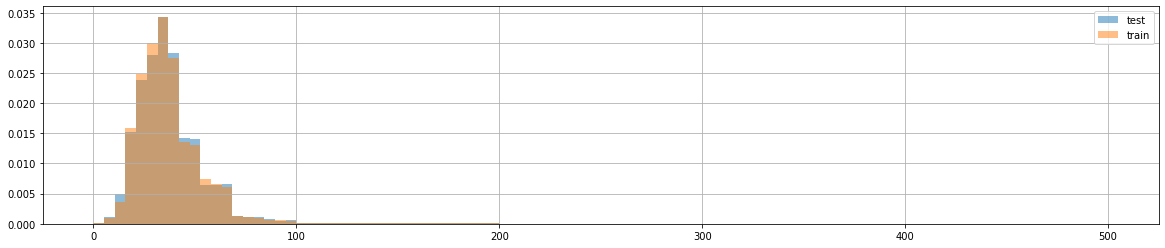

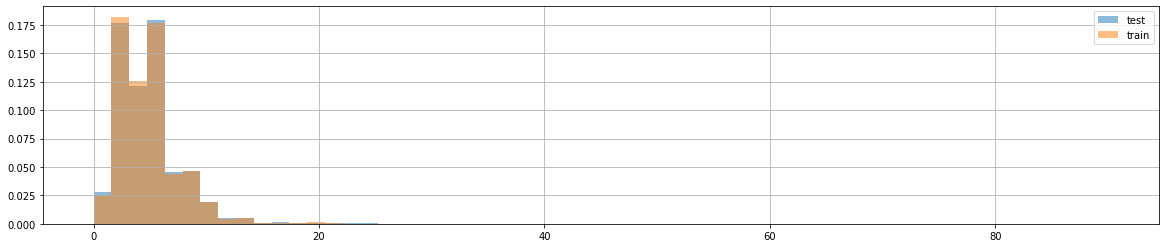

In [22]:
# Распределение по символам
bins = list(np.linspace(0, 100, num=20))+list(np.linspace(200, 500, num=3))
df_test['name'].apply(len).hist(normed = True, alpha = 0.5, label = 'test', bins = bins, figsize = (20, 4))
df['name'].apply(len).hist(normed = True, alpha = 0.5, label = 'train', bins = bins)
plt.legend()
plt.show()


# Распределение по словам
bins = list(np.linspace(0, 30, num=20))+list(np.linspace(40, 90, num=3))
df_test['name'].apply(lambda x:x.count(' ')).hist(normed = True, 
                                                  bins = bins,
                                                  alpha = 0.5,
                                                  label = 'test', 
                                                  figsize = (20, 4))

df['name'].apply(lambda x:x.count(' ')).hist(normed = True, 
                                             bins = bins,
                                             alpha = 0.5, 
                                             label = 'train',)
plt.legend()
plt.show()

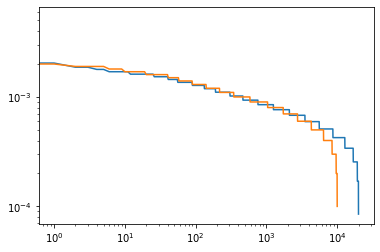

In [23]:
# Проверка на глаз закона Ципфа
text_test  = '\n'.join(df_test['name'].apply(simple_preprocessor))
text_train = '\n'.join(df['name'].apply(simple_preprocessor))
words = [i for i in set((text_train+'\n'+text_test).split(' ')) if len(i)>=2]
vect = CountVectorizer().fit((text_test+text_train).split('\n'), words)
M_test = vect.transform(df_test['name'].apply(simple_preprocessor))
M_train = vect.transform(df['name'].apply(simple_preprocessor))

M_test  = sorted(np.array(M_test.sum(axis = 1)).ravel()/M_test.shape[0], reverse = True)
M_train = sorted(np.array(M_train.sum(axis = 1)).ravel()/M_train.shape[0], reverse = True)

plt.plot(np.array(M_test)*(M_train[10]/M_test[10]))
plt.plot(M_train)
plt.xscale('log')
plt.yscale('log')

del M_train, M_test, words, text_train, text_test

In [24]:
model_M1.fit(X, y)
df_test['predict_Rothmands'] = model_M1.predict(df_test['name'])

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### Для двух моделей на тесте, видно что baseline работает сильно хуже, поскольку несет в себе много незначящих фичей
Например опредялет сигареты кент как Rothmands

In [25]:
df_test[df_test['predict_baseline']=='Plus Blue']

name predict_baseline  \
97                    cиг. "kent" nanotek микс амбер        Plus Blue   
2160                 сигареты "кент" нано микс амбер        Plus Blue   
3285                      сиг. rothmans demi 90 руб.        Plus Blue   
4506           сигареты кент нано микс амбер мрц125р        Plus Blue   
8181               сигареты кент нано микс амбер 125        Plus Blue   
11436                   сигареты"rothmans demi"амбер        Plus Blue   
11616       rothmans demi амбер сигареты 20 шт./100/        Plus Blue   
11823      1. сигареты ротманс деми амбер 90руб (шт)        Plus Blue   
11881                             ротманс деми амбер        Plus Blue   
12254                 ротмнс деми плюс кнопка мрц 95        Plus Blue   
12314           rothmans demi амбер мандарин (95-00)        Plus Blue   
12529              сигареты rothmans demi clik амбер        Plus Blue   
12567                       ротманс деми амбер/95руб        Plus Blue   
12783                сигареты "ротманс деми амбер" 1        Plus Blue   
13237               rothmans demi капсула деми амбер        Plus Blue   
13269    ротманс деми плюс блю (мандарин) мрц 95 руб        Plus Blue   
13292      сиг ротманс деми амбер (мандарин): 100 р.        Plus Blue   
13366              ротманс деми плюс блю мандарин шт        Plus Blue   
13440                     сигар. rothmans demi амбер        Plus Blue   
13727                 ротманс деми амбер мрц 95 руб.        Plus Blue   
14066                     ротманс деми амбер (мрц90)        Plus Blue   
14088    3. сигареты ротманс деми клик амбер 90 (шт)        Plus Blue   
14401     сигареты ротманс деми плюс блю амбер мрц95        Plus Blue   
14620      сигареты ротманс деми клик амбер мандарин        Plus Blue   
14857             сигареты rothmans demi click амбер        Plus Blue   
15133                    ротманс деми плюс оранж 100        Plus Blue   
15165      сигареты rothmans demi амбер с мандарином        Plus Blue   
15170           ротманс деми амбер(мандарин) мрц 100        Plus Blue   
15313      сигареты "rothmans" demi амбер нидерланды        Plus Blue   
15957                  ротманс деми амбер (мандарин)        Plus Blue   
16117                сигареты ротманс деми амбер: 95        Plus Blue   
16144               сигареты rothmans demi амбер 85р        Plus Blue   
16174                  ротманс деми амбер с капсулой        Plus Blue   
16268            сигареты rothmans demi амбер(оранж)        Plus Blue   
16363   с* сиг. ротманс деми плюс блу (мандарин), шт        Plus Blue   
16392           сиг ротманс деми амбер 95-00мандарин        Plus Blue   
16405               ротманс деми амбер цитрус, 100 р        Plus Blue   
16646  сигареты ротманс деми деми амбер кнопка(желт)        Plus Blue   
17178                       смгареты кент микс амбер        Plus Blue   

      predict_Rothmands  
97                  NOT  
2160                NOT  
3285          Rothmands  
4506                NOT  
8181                NOT  
11436         Rothmands  
11616         Rothmands  
11823         Rothmands  
11881         Rothmands  
12254         Rothmands  
12314         Rothmands  
12529         Rothmands  
12567         Rothmands  
12783         Rothmands  
13237         Rothmands  
13269         Rothmands  
13292         Rothmands  
13366         Rothmands  
13440         Rothmands  
13727         Rothmands  
14066         Rothmands  
14088         Rothmands  
14401         Rothmands  
14620         Rothmands  
14857         Rothmands  
15133         Rothmands  
15165         Rothmands  
15170         Rothmands  
15313         Rothmands  
15957         Rothmands  
16117         Rothmands  
16144         Rothmands  
16174         Rothmands  
16268         Rothmands  
16363         Rothmands  
16392         Rothmands  
16405         Rothmands  
16646         Rothmands  
17178               NOT

## Модель для подкатегорий

In [26]:
df_M2 = df[df['y_M1']!='NOT' ]

/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

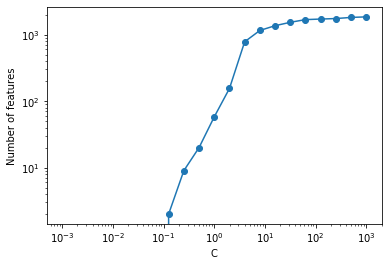

In [27]:
X, y = df_M2['name'].to_numpy(), df_M2['y'].to_numpy()
C_log = list(map(lambda x:10**x, np.linspace(-3,3,21)))
y_list = []
for C in tqdm.tqdm_notebook(C_log):
    used_features = get_features_list(C, X, y)
    y_list.append(len(set(used_features)))
    
plt.plot(C_log, y_list)
plt.scatter(C_log, y_list)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('Number of features')
plt.show()

In [28]:
used_features = get_features_list(2, X, y)
print(len(set(used_features)))
print('["'+'", "'.join(list(set(used_features)))+'"]')

156
["rothmans demi 95", "деми клик", "демиi", "сигареты", "rothmans demi мрц", "ротманс деми мрц", "амбер", "аэро", "клик", "ровалс", "мандар", "аэроблю мрц 95", "orange", "деми kлиk", "ротманс деми kлиk", "plus", "royals rothmans demi", "деми ягод", "сигареты ротманс деми", "of london demi click", "фильтром", "royals demi click", "аэроблю мрц", "kлиk", "ротманс деми 100", "оранж", "ментол", "сигареты rothmans demi click", "91410", "ротманс деми мрц100", "силвер", "плюс", "серый", "46129185сигареты ротманс", "деми кл", "сигареты ротманс деми шт", "деми силвер", "demi click", "деми 95", "ротманс деми апельсин", "rothmans demi amber", "ротманс деми шт", "аэроблю", "rothmans demi clik", "ротманс деми aмбер", "ягоды", "90", "рояль", "пач", "сигареты фильтром rothmans", "of", "деми мрц100", "ротманс деми слик", "деми слик", "kлик", "91410 rothmans demi", "сигареты rothmans demi", "rothmans demi blue", "ротманс деми ровалс", "ротманс деми ягод", "деми мрц", "100 00", "demi 100", "деми блю",

/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  fb  = (1+betta**2)*pr*rec/(pr*(betta**2)+rec)


In [29]:
vocM2 =["rothmans demi", "роял", "мандар", "ротманс деми слик", "rothmans demi клик", "click", 
        "фиолет", "ротманс деми рояль", "rothmans demi click", "ротманс демиi", "demi", "син", 
        "фильтром", "aмбер", "demi amber", "клик мрц", "ротманс деми цитрус", "ротманс деми ягод",
        "силвер", "деми шт", "ротманс деми син", "rothmans demi blue", "orange", "комп", 
        "ротманс деми aмбер", "plus", "деми комп", "деми ягод", "demi clik", "амбер", "ротманс деми kлиk", 
        "demi клик", "aero", "сигареты rothmans", "ровалс", "деми kлиk", "синие", "деми силвер", "демиi", 
        "деми ровалс", "деми клик", "слик", "royals demi click", "деми кл", "clik", "роялс", "kлик", 
        "royals rothmans demi", "ментол", "деми фиол", "blue", "ротманс деми ровалс", "фильтром rothmans",
        "ротманс деми шт", "серый", "сигареты ротманс деми", "аэроблю", "деми апельсин", "деми цитрус", 
        "demi click", "лайм", "деми рояль", "сигареты ротманс", "kлиk", "блю", "мандарином", "ротманс",
        "kапсула", "клик", "пач", "ягода", "royals", "ротманс деми блю", "деми слик", "деми", "деми 1п", 
        "amber", "rothmans demi silver", "аэроблю мрц", "rothmans", "ротманс деми", "ротманс деми силвер",
        "деми aмбер", "мандарин", "цитрус", "оранж", "сигареты ротманс деми апельсин", "фиол", "сильвер",
        "silver", "ягод", "сигареты ротманс деми шт", "ротманс деми фиол", "кл", "рояль", "аэро", "деми kлик",
        "ягоды", "сигареты фильтром rothmans", "royals rothmans", "ротманс деми кл", "капсула", 
        "сигареты rothmans demi", "деми блю", "rothmans demi clik", "плюс", "ротманс деми апельсин", 
        "деми мрц", "сигареты ротманс деми клик", "мрц", "деми син", "rothmans demi amber", "rothmans demi мрц", 
        "синий", "rothmans royals demi click", "апельсин", "london demi click"]


In [30]:
model_M2 = Pipeline([('Tf-IDF', CountVectorizer(lowercase=True, vocabulary=vocM2,
                                                preprocessor=simple_preprocessor,
                                                ngram_range=(1,1), max_features=100)),
                     ('SVC', SVC(kernel='linear', probability=True, class_weight='balanced'))])


# Запускаем обучение
y_truth, y_predict_list, texts = evaluate_model(X, y, model_M2, fold, print_scores=True)

# Выводим рузультат в виде confusion_matrix
confusion_matrix_with_names(y_truth, y_predict_list)

# Выведем precision и recall по классам
labels = [i[0] for i in sorted(Counter(y_truth).items(), key = lambda x:-x[1])]
print(classification_report(y_truth, y_predict_list, labels = labels, digits=5))
# print('["'+'", "'.join(list(set(list(set(vocM2)))))+'"]')

/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()


classes:  DEMI CLICK  Plus Blue   DEMI        DEMI SILVER ROYALS BY   Aero Blue   WRONG CHECK
Pr:       0.9412      1.0000      0.7692      1.0000      0.7826      0.9231      nan        
Rec:      0.8571      0.9362      0.9302      1.0000      0.9474      0.8000      0.0000     
F01:      0.9403      0.9993      0.7706      1.0000      0.7840      0.9217      nan        
classes:  DEMI CLICK  Plus Blue   DEMI        DEMI SILVER ROYALS BY   Aero Blue   WRONG CHECK
Pr:       0.9298      0.9750      0.7321      1.0000      0.8947      1.0000      nan        
Rec:      0.9464      0.8478      0.9535      0.8947      0.8947      0.7333      0.0000     
F01:      0.9300      0.9736      0.7338      0.9988      0.8947      0.9964      nan        
classes:  DEMI CLICK  Plus Blue   DEMI        DEMI SILVER ROYALS BY   Aero Blue   WRONG CHECK
Pr:       0.8772      0.9756      0.7069      1.0000      0.7368      1.0000      nan        
Rec:      0.9091      0.8696      0.9535      0.9474      0.

/Users/adam/Documents/ofd_test_task/git/task_ofd/notebooks/utils.py:56: RuntimeWarning: invalid value encountered in long_scalars
  pr  = M[c, c]/M[c, :].sum()
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### У нас пооучилось необольшими усилиями значимо увеличить метрики

#### Стало 
                precision    recall  f1-score   support

      DEMI CLICK    0.91244   0.89189   0.90205       222
       Plus Blue    0.98788   0.88108   0.93143       185
            DEMI    0.73009   0.95930   0.82915       172
     DEMI SILVER    1.00000   0.93421   0.96599        76
       ROYALS BY    0.83333   0.86667   0.84967        75
       Aero Blue    0.97561   0.67797   0.80000        59
     WRONG CHECK    0.00000   0.00000   0.00000         9
     
#### Было

                precision    recall  f1-score   support

             NOT    0.99870   0.99848   0.99859      9200
      DEMI CLICK    0.72477   0.71171   0.71818       222
       Plus Blue    0.82734   0.62162   0.70988       185
            DEMI    0.45373   0.88372   0.59961       172
     DEMI SILVER    0.88235   0.78947   0.83333        76
       ROYALS BY    0.57895   0.14667   0.23404        75
       Aero Blue    0.38095   0.13559   0.20000        59
     WRONG CHECK    0.00000   0.00000   0.00000         9

        accuracy                        0.96919      9998
       macro avg    0.60585   0.53591   0.53670      9998
    weighted avg    0.97149   0.96919   0.96755      9998

In [31]:
model_M2.fit(X, y)
df_test['predict_M2'] = model_M2.predict(df_test['name'])

In [32]:
df_test['predict_M2'].value_counts()

DEMI           18777
WRONG CHECK      469
DEMI SILVER      248
Plus Blue        236
DEMI CLICK       175
ROYALS BY         44
Aero Blue         40
Name: predict_M2, dtype: int64

In [33]:
def foo(y1, y2):
    if y1=='Rothmands':
        return y2
    else:
        return y1
df_test['predict'] = [foo(y1, y2) for y1, y2 in df_test[['predict_Rothmands', 'predict_M2']].to_numpy()]

In [34]:
df_test['predict'].value_counts()

NOT            19779
DEMI              64
DEMI CLICK        54
Plus Blue         42
DEMI SILVER       18
ROYALS BY         14
Aero Blue         10
WRONG CHECK        8
Name: predict, dtype: int64

In [35]:
df_test[df_test['predict']=='Aero Blue']

name predict_baseline  \
10286          сигареты "rothmans demi click - аэро блю"        Aero Blue   
10368                сигареты ротманс деми клик аэро блю        Aero Blue   
10767  сигареты ротманс деми клик аэро блю 20 шт т/у ...        Aero Blue   
10835  ротманс аэро блю с кнопкой фиолет.1пач(100)дем...      WRONG CHECK   
11004     ротманс деми клик лесные ягоды сигареты, 20шт.       DEMI CLICK   
11047                  сигареты ротманс деми аэро фиолет        ROYALS BY   
11050  сигареты rothmans аэро блю demi click в подаро...        Aero Blue   
11175     сигареты ротманс деми аэро блю (ягода фиолет.)      WRONG CHECK   
11208                   сигареты "ротманс" деми аэро блю      WRONG CHECK   
11212          сигареты ротманс деми клик аэро блю 20 шт        Aero Blue   

      predict_Rothmands predict_M2    predict  
10286         Rothmands  Aero Blue  Aero Blue  
10368         Rothmands  Aero Blue  Aero Blue  
10767         Rothmands  Aero Blue  Aero Blue  
10835         Rothmands  Aero Blue  Aero Blue  
11004         Rothmands  Aero Blue  Aero Blue  
11047         Rothmands  Aero Blue  Aero Blue  
11050         Rothmands  Aero Blue  Aero Blue  
11175         Rothmands  Aero Blue  Aero Blue  
11208         Rothmands  Aero Blue  Aero Blue  
11212         Rothmands  Aero Blue  Aero Blue

In [36]:
df_test['result'] = df_test['predict'].apply(lambda x:rename_dict_inverse[x])

In [37]:
# Сохраним результаты
sample_submission= df_test[['name', 'result']]
sample_submission.to_csv('classified_dataset.txt', 
                         index = None,  sep = '\t')

In [38]:
# Сохраним модели
pickle.dump(model_M1, open('model_M1.pickle', 'wb'))
pickle.dump(model_M2, open('model_M2.pickle', 'wb'))

model

#### Как в дальнейшем возможно улучшить модель?

In [39]:
def _draw_pr_curve(y, p, classes):
    plt.figure(figsize = (20, 10))
    for c, cl in enumerate(classes):
        _y = [int(i==cl) for i in y]
        _p = p[:, c]
        precision, recall, thresholds = precision_recall_curve(_y, _p)
        plt.plot(recall, precision, label = cl)
    plt.legend()
    plt.show()

_draw_pr_curve(y, pp, model_M2.classes_)

NameError: name 'pp' is not defined

In [ ]:
class fooClass():
    def __init__(self, model, t=0.8):
        self.model = model
        self.t = t

    def fit(self, X, y):
        self.model.fit(X, y)
        self.classes_ = self.model.classes_
        
    def predict_proba(self, X, y=None):
        M = self.model.predict_proba(X)
        M = np.array(M>self.t, dtype=int)
        print(M.shape)
        print(M)
        _lst = np.where(M.sum(axis = 1)!=1)
        M[_lst, [-1 for i in _lst]] = 1
        return M
    
    def classes_(self):
        return self.model.steps[1][1].classes_

In [45]:
rename_dict_inverse = {'NOT': 'НЕ Сигареты ROTHMANS',
                     'DEMI': 'Сигареты ROTHMANS DEMI',
                     'Aero Blue': 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)',
                     'Plus Blue': 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)',
                     'DEMI CLICK': 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)',
                     'DEMI SILVER': 'Сигареты ROTHMANS DEMI SILVER (серый)',
                     'ROYALS BY': 'Сигареты ROYALS BY ROTHMANS',
                     'WRONG CHECK': 'Сигареты ROTHMANS (неизвестно или нет в списке)'}

{'NOT': 'НЕ Сигареты ROTHMANS',
 'DEMI': 'Сигареты ROTHMANS DEMI',
 'Aero Blue': 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)',
 'Plus Blue': 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)',
 'DEMI CLICK': 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)',
 'DEMI SILVER': 'Сигареты ROTHMANS DEMI SILVER (серый)',
 'ROYALS BY': 'Сигареты ROYALS BY ROTHMANS',
 'WRONG CHECK': 'Сигареты ROTHMANS (неизвестно или нет в списке)'}

## Trash